# For Issue 1279 | 311 Geospatial Analysis
---
Identify addresses or small areas that could benefit from more signage, increased community assistance, or other actions

# Package & Data Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# https://stackoverflow.com/questions/13440102/getting-bounding-box-of-city
import geopandas
from geopandas import GeoDataFrame, GeoSeries
from pyproj import CRS
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from shapely.geometry import Point, Polygon
import googlemaps

# https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/
import folium
from branca.element import Figure
import re
import matplotlib
from folium.plugins import TimeSliderChoropleth

from titlecase import titlecase
%matplotlib inline

In [2]:
# 311 Data from API see 01 notebook
raw_df = pd.read_csv('./data/clean_23Sept21_23Sept22_api.csv')
df = raw_df.copy()

# https://geopandas.org/en/stable/getting_started/introduction.html
# NC boundaries: https://data.lacity.org/City-Infrastructure-Service-Requests/Neighborhood-Councils-Certified-/fu65-dz2f
raw_gdf = geopandas.read_file("./data/Neighborhood Councils (Certified)/geo_export_88bb18d9-f96c-4351-8be9-594f258ed0d3.shp")
gdf = raw_gdf.copy()

# Data Cleaning
---

In [3]:
# to datetime
df['createdDate'] = pd.to_datetime(df['createdDate'])
df['closedDate'] = pd.to_datetime(df['closedDate'])

print(df.shape)
df.head()

(12683, 16)


,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
0,10638532,2022-09-19 11:07:22,2022-09-20 09:35:20,4,Bulky Items,"11225 N SIERRA PASS PL, 91311","(34.2747211947, -118.610043043)",34.274721,-118.610043,3,Sanitation Bureau,8,1-2500995851,Phone Call,11,Chatsworth
1,10638534,2022-09-19 11:07:35,2022-09-20 10:11:11,7,Metal/Appliances,"243 S AVENUE 50, 90042","(34.1029581842, -118.200271159)",34.102958,-118.200271,3,Sanitation Bureau,17,1-2500998901,Website,39,Historic Highland Park
2,10638536,2022-09-19 11:07:42,2022-09-21 07:34:01,4,Bulky Items,"17162 W PARTHENIA ST, 91325","(34.2283765872, -118.508080576)",34.228377,-118.508081,3,Sanitation Bureau,17,1-2500997561,Website,59,Northridge South
3,10638537,2022-09-19 11:07:53,2022-09-21 12:05:30,7,Metal/Appliances,"1833 S MANNING AVE, 90025","(34.0514359143, -118.430501451)",34.051436,-118.430501,3,Sanitation Bureau,8,1-2500999011,Phone Call,93,Westside
4,10638538,2022-09-19 11:07:54,2022-09-20 10:19:24,1,Graffiti,"17308 W SATICOY ST, 91406","(34.2082575227, -118.510410902)",34.208258,-118.510411,4,Office of Community Beautification,17,1-2500997651,Website,44,Lake Balboa


In [4]:
# get necessary columns; objectid = councilId
gdf = gdf[['name', 'nc_id', 'objectid', 'service_re', 'geometry']].sort_values(by = 'nc_id').reset_index(drop = True)

# format data
gdf['name'] = gdf['name'].apply(lambda x: titlecase(x.strip(' NC')))
gdf['service_re'] = gdf['service_re'].apply(lambda x: titlecase(x))
gdf['nc_id'] = gdf['nc_id'].apply(lambda x: int(x))
gdf['objectid'] = gdf['objectid'].apply(lambda x: int(x))

print(gdf.shape)
gdf.head()

(99, 5)


,name,nc_id,objectid,service_re,geometry
0,Granada Hills North,4,27,Region 2 - North West Valley,"POLYGON ((-118.50737 34.33461, -118.50570 34.3..."
1,Sylmar,5,79,Region 1 - North East Valley,"POLYGON ((-118.50737 34.33461, -118.50380 34.3..."
2,Arleta,6,1,Region 1 - North East Valley,"POLYGON ((-118.45005 34.24992, -118.45055 34.2..."
3,Pacoima,7,63,Region 1 - North East Valley,"POLYGON ((-118.41566 34.29392, -118.40815 34.2..."
4,Sun Valley Area,8,77,Region 1 - North East Valley,"POLYGON ((-118.36516 34.22933, -118.36400 34.2..."


## Checking Consistency Between gdf and df
#### To Note:
- df['councilID'] == gdf['objectiid']
- df contains a 0 ID for No Council

In [5]:
print(f"Number of Council Names in gdf: {len(gdf['name'].unique())}")
print(f"Number of Council Names in df: {len(df['councilName'].unique())}")
print(f"Number of Council # in gdf: {len(gdf['objectid'].unique())}")
print(f"Number of Council # in df: {len(df['councilId'].unique())}")

Number of Council Names in gdf: 99
Number of Council Names in df: 100
Number of Council # in gdf: 99
Number of Council # in df: 100


In [6]:
df[df['councilName'] == 'Glassell Park'].head(1)

,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
157,10638820,2022-09-19 11:26:33,2022-09-20 14:20:41,4,Bulky Items,"3922 N RODERICK ROAD, 90065","(34.1205995349, -118.231514218)",34.1206,-118.231514,3,Sanitation Bureau,17,1-2501036491,Website,26,Glassell Park


In [7]:
gdf[gdf['name'] == 'Glassell Park']

,name,nc_id,objectid,service_re,geometry
32,Glassell Park,39,26,Region 8 - North East La,"POLYGON ((-118.25412 34.11885, -118.25113 34.1..."


In [8]:
print(f"Council #'s in gdf: {sorted([nc for nc in gdf['objectid'].unique()])}")
print()
print(f"Council #'s in df: {sorted([nc for nc in df['councilId'].unique()])}")

Council #'s in gdf: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

Council #'s in df: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [9]:
gdf[gdf['objectid'] == 1]

,name,nc_id,objectid,service_re,geometry
2,Arleta,6,1,Region 1 - North East Valley,"POLYGON ((-118.45005 34.24992, -118.45055 34.2..."


In [10]:
df[df['councilId'] == 1].head(1)

,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
101,10638727,2022-09-19 11:17:15,2022-09-19 11:17:53,1,Graffiti,"13928 W TERRA BELLA ST, 91331","(34.2449424541, -118.436380439)",34.244942,-118.43638,4,Office of Community Beautification,18,1-2501016331,Work Crew,1,Arleta


# Geospatial Variable Creation
---

In [66]:
gdf = gdf[['geometry', 'objectid']]
df = df[['requestId', 'createdDate', 'councilId', 'latitude', 'longitude']].sort_values(by = 'createdDate')

In [67]:
gdf.head(1)

,geometry,objectid
0,"POLYGON ((-118.50737 34.33461, -118.50570 34.3...",27


In [68]:
df.head(1)

,requestId,createdDate,councilId,latitude,longitude
0,10638532,2022-09-19 11:07:22,11,34.274721,-118.610043


In [69]:
# create df of running count of requests per neighborhood council
df_ct = df.groupby(['createdDate','councilId', 'latitude', 'longitude'])['requestId'].agg('count').reset_index(name = 'request_ct')
df_ct['nc_running_ct'] = df_ct.groupby('councilId')['request_ct'].cumsum()

# add color variable for mapping
# https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/
bins=np.linspace(min(df_ct['nc_running_ct']),max(df_ct['nc_running_ct']),11)
df_ct['color']=pd.cut(df_ct['nc_running_ct'],bins,labels=['#FFEBEB','#F8D2D4','#F2B9BE','#EBA1A8','#E58892','#DE6F7C','#D85766','#D13E50','#CB253A','#C50D24'],include_lowest=True)
df_ct_plt = df_ct[['createdDate', 'color', 'councilId']]
df_ct_plt.head()

,createdDate,color,councilId
0,2022-09-19 11:07:22,#FFEBEB,11
1,2022-09-19 11:07:35,#FFEBEB,39
2,2022-09-19 11:07:42,#FFEBEB,59
3,2022-09-19 11:07:53,#FFEBEB,93
4,2022-09-19 11:07:54,#FFEBEB,44


In [70]:
# TimeSliderCloropleth
# https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/
# convert datetime to TimeSliderCloropleth accepted format
df_ct_plt['createdDate'] = (df_ct_plt['createdDate'].astype(int)// 10**9).astype('U10')
df_ct_plt['createdDate'] = df_ct_plt['createdDate'].apply(lambda x: int(x))

# create dictionary for TimeSliderCloropleth
df_dict={}
for i in df_ct_plt['councilId'].unique():
    df_dict[i]={}
    for j in df_ct_plt[df_ct_plt['councilId']==i].set_index(['councilId']).values:   
        df_dict[i][j[0]]={'color':j[1],'opacity':0.7}

/var/folders/5f/3tr4k1qn1fx81cd1l2y9j2100000gn/T/ipykernel_46179/1200316419.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ct_plt['createdDate'] = (df_ct_plt['createdDate'].astype(int)// 10**9).astype('U10')
/var/folders/5f/3tr4k1qn1fx81cd1l2y9j2100000gn/T/ipykernel_46179/1200316419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ct_plt['createdDate'] = df_ct_plt['createdDate'].apply(lambda x: int(x))


In [76]:
# list(df_dict.items())[1]

# Geospatial Basemapping
---

In [63]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [64]:
gdf_plt = gdf.to_json()

In [77]:
# Basemap
fig = Figure(height = 850, width = 1000)
m = folium.Map([34, 118], tiles='cartodbpositron', zoom_start=5)
fig.add_child(m)

# TimeSliderCloropleth
g = TimeSliderChoropleth(
    gdf_plt,
    styledict = df_dict
).add_to(m)
m

TypeError: keys must be str, int, float, bool or None, not numpy.int64

In [19]:
# Basemap
fig = Figure(width=550,height=350)
m1=folium.Map(width=550,height=350,location=[28.644800, 77.216721],zoom_start=11,min_zoom=8,max_zoom=14)
fig.add_child(m1)

# Add tiles
folium.TileLayer('Stamen Terrain').add_to(m1)
folium.LayerControl().add_to(m1)

# Add Markers
folium.Marker(location=[28.695800, 77.244721],popup='Default popup Marker1',tooltip='Click here to see Popup').add_to(m1)
folium.Marker(location=[28.645800, 77.214721],popup='<strong>Marker3</strong>',tooltip='<strong>Click here to see Popup</strong>').add_to(m1)
folium.Marker(location=[28.655800, 77.274721],popup='<h3 style="color:green;">Marker2</h3>',tooltip='<strong>Click here to see Popup</strong>').add_to(m1)

m1

<AxesSubplot:>

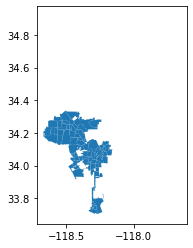

In [20]:
gdf.plot()